<img src=".\Markdown\AUEB_LOGO.jpg " alt="Athens University of Economics and Business" style="width: 50%"/>

 **Instructor**: Ted Lappas, Assistant Professor <br />
 **Author**: Antonios Mavridis, Postgraduate Student <br /> 
 **AM**: p3352215  <br /> 
 **Email**: amavridis@aueb.gr <br /> <br />

 MSc in Data Science  <br />
 Course: Advanced Customer Analytics  <br /> <br />
 Departnment of Informatics <br />
 Athens University of Economics and Business  <br />


---
## Topic Modelling

Following the web scraping phase, we embarked on a topic modeling exercise to analyze the collected textual data. Our approach utilized two prominent methods: **Latent Dirichlet Allocation (LDA)** and **Latent Semantic Indexing (LSI)**, both from the **Gensim** library. These methods are well-suited for uncovering the underlying thematic structure in large datasets, like the one we amassed from Reuters.

**LDA**: is a probabilistic model that assumes documents are mixtures of topics, where each topic is characterized by a distribution over words. We employed this model to discern distinct topics across our corpus, aiming to understand the key themes in the Israel-Hamas/Palestine conflict as presented in the articles. This method helped us in identifying the various angles and narratives prevalent in the news coverage.

**LSI**: is a technique that uses singular value decomposition to reduce the dimensionality of text data, effectively capturing the essence of words and their relationships in a lower-dimensional space. 

### Importing Necessary Libraries

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models import LsiModel
from gensim.matutils import Sparse2Corpus
from sklearn.metrics import silhouette_score
import nltk
import seaborn as sns
import os
import math

### Initialization of functions

In [17]:
def add_topic_titles(df: pd.Dataframe, 
                     topic_titles: dict) -> pd.Dataframe:
    """
    Adds a new column to the DataFrame with titles based on the dominant topic number.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the dominant topic numbers.
    topic_titles (dict): Dictionary mapping topic numbers to topic titles.

    Returns:
    pandas.DataFrame: DataFrame with an additional column for topic titles.
    """
    
    # Function to map topic number to topic title
    def map_topic_title(topic_num):
        return topic_titles.get(topic_num, "Unknown Topic")

    df['Topic_Title'] = df['Dominant_Topic'].apply(map_topic_title)

    return df

def plot_topic_frequencies(df: pd.DataFrame, 
                           topic_number_column: str, 
                           topic_title_column: str):
    """
    Generates a horizontal bar plot to display the frequencies of different topics in a DataFrame.
    This function calculates the frequency of each topic based on a specified column and uses another column
    for topic titles to enhance readability of the plot.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the topic data.
    topic_number_column (str): The name of the column in the DataFrame that contains topic numbers.
    topic_title_column (str): The name of the column in the DataFrame that contains topic titles.

    The function creates a plot where the x-axis represents the frequency of each topic and the y-axis
    displays the corresponding topic titles. It also annotates the plot with the frequency values.
    """
    
    
    sns.set(style="whitegrid")

    # Calculate topic frequencies
    topic_freq = df[topic_number_column].value_counts().sort_index()

    # Map topic numbers to titles for plotting
    topic_titles = dict(df[[topic_number_column, topic_title_column]].drop_duplicates().values)
    labels = [topic_titles[i] for i in topic_freq.index]

    # Create horizontal bar plot
    plt.figure(figsize=(12, 7))
    barplot = sns.barplot(x=topic_freq.values, y=labels, palette="mako", orient='h')

    # Add annotations
    for p in barplot.patches:
        width = p.get_width()
        plt.text(width + 0.3, p.get_y() + 0.55 * p.get_height(),
                 '{:1.2f}'.format(width),
                 ha='center', va='center')

    # Set plot title and labels
    plt.title('Frequency of Dominant Topics', fontsize=18)
    plt.xlabel('Frequency', fontsize=16)
    plt.ylabel('Topic Title', fontsize=16)

    # Show plot
    plt.tight_layout()
    plt.show()
    
def topic_correlation_analysis(models: dict,
                               X, 
                               n_topics_range, 
                               save_folder: str):
    """
    Performs a topic correlation analysis for a range of topic models and visualizes the results using heatmaps.
    This function calculates the correlation between topics for each model and generates a heatmap for each
    number of topics specified in the range. The generated heatmaps are saved in a specified folder.

    Parameters:
    models (dict): A dictionary of trained topic models, keyed by the number of topics.
    X (array-like): The document-topic distribution matrix obtained from the topic models.
    n_topics_range (iterable): An iterable of integers specifying the range of topic numbers to analyze.
    save_folder (str): The directory path where the heatmaps will be saved.

    For each number of topics in the given range, the function computes a correlation matrix between topics,
    creates a heatmap for visualizing these correlations, and saves the heatmap as an image file. The heatmaps
    display correlations between each pair of topics, aiding in understanding the relationships between different
    topics within the models.
    """
    
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    for k in n_topics_range:
        model = models[k]
        lda_output = model.transform(X)

        # Compute the topic-topic correlation matrix
        topic_correlation_matrix = np.corrcoef(lda_output, rowvar=False)

        # Create a mask for the upper triangle
        mask = np.triu(np.ones_like(topic_correlation_matrix, dtype=bool))

        cmap = 'RdYlBu_r'

        # Plot the heatmap
        plt.figure(figsize=(12, 10))
        heatmap = sns.heatmap(topic_correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap=cmap, 
                              xticklabels=[f"Topic {i+1}" for i in range(k)], 
                              yticklabels=[f"Topic {i+1}" for i in range(k)],
                              cbar=True, cbar_kws={"shrink": .75})

        # Adjust annotation color for better visibility
        for text in heatmap.texts:
            threshold = topic_correlation_matrix.max() / 2.
            text.set_color("black" if float(text.get_text()) < threshold else "black")

        # Enhance title and labels
        plt.title(f"Topic Correlation Matrix for {k} Topics", fontsize=16)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)

        # Adjust layout
        plt.tight_layout()

        # Save the plot
        plt.savefig(f"Images/{save_folder}_lda/topic_correlation_{k}_topics.png")
            
        plt.show()

def lda_topic_modeling_tfidf(df: pd.DataFrame, 
                             column: str, 
                             use_tfidf=True, 
                             n_topics_range=range(3, 16), 
                             n_top_words=25):
    """
    Performs LDA topic modeling on a text column of a DataFrame, with an option to use TF-IDF for vectorization.
    It calculates coherence and log perplexity scores for different numbers of topics to evaluate the models,
    identifies the best model based on coherence, and adds the most dominant topic for each document as a new column.

    Parameters:
    df (pd.DataFrame): DataFrame containing the text data.
    column (str): Name of the column in df containing the text to be analyzed.
    use_tfidf (bool, optional): If True, TF-IDF vectorization is used; otherwise, CountVectorizer is used. Default is True.
    n_topics_range (range, optional): Range of topic numbers to consider for the LDA models. Default is range(3, 16).
    n_top_words (int, optional): Number of top words to consider for each topic. Default is 25.

    This function vectorizes the text data, applies LDA topic modeling for the specified range of topic numbers,
    and evaluates each model using coherence and log perplexity scores. The function identifies the best model
    based on the highest coherence score, prints the top words for each topic in the best model, and appends a column
    to the original DataFrame indicating the most dominant topic for each document.

    Returns:
    tuple: A tuple containing the dictionary of LDA models keyed by number of topics, the document-topic distribution matrix, 
    and the modified DataFrame with a new column for the dominant topic.
    """
        
    # Vectorization
    if use_tfidf:
        vectorizer = TfidfVectorizer()
    else:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df[column])
    words = vectorizer.get_feature_names_out()

    # Convert sparse matrix to gensim corpus
    corpus = Sparse2Corpus(X, documents_columns=False)
    dictionary = Dictionary.from_corpus(corpus, id2word=dict(enumerate(words)))

    coherence_scores = []
    log_perplexity_scores = []
    models = {}  
    best_coherence = 0
    best_model = None
    best_k = 0

    for k in n_topics_range:
        lda_model = LatentDirichletAllocation(n_components=k, random_state=0)
        lda_output = lda_model.fit_transform(X)

        # Extract topics for coherence calculation
        topics = [[words[i] for i in topic.argsort()[:-n_top_words - 1:-1]] for topic in lda_model.components_]

        # Compute Coherence Score
        coherence_model_lda = CoherenceModel(topics=topics, texts=df[column].apply(lambda x: x.split()), dictionary=dictionary, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        coherence_scores.append(coherence_lda)

        if coherence_lda > best_coherence:
            best_coherence = coherence_lda
            best_model = lda_model
            best_k = k

        # Compute Log Perplexity
        log_perplexity = math.log(lda_model.perplexity(X))
        log_perplexity_scores.append(log_perplexity)

        # Store the model
        models[k] = lda_model

        print(f"Topics: {k}, Coherence Score: {coherence_lda}, Log Perplexity: {log_perplexity}")

    # Plotting coherence and log perplexity scores
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(list(n_topics_range), coherence_scores, marker='o', color='b', linestyle='-', linewidth=2, markersize=8)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title("Coherence Scores for Different Number of Topics")

    plt.subplot(1, 2, 2)
    plt.plot(list(n_topics_range), log_perplexity_scores, marker='o', color='r', linestyle='-', linewidth=2, markersize=8)
    plt.xlabel("Number of Topics")
    plt.ylabel("Log Perplexity")
    plt.title("Log Perplexity for Different Number of Topics")
    plt.show()

    print(f"Best Number of Topics: {best_k}")
    
    # Print the topics with words
    def print_topics(model, top_n=n_top_words):
        for idx, topic in enumerate(model.components_):
            print("Topic %d:" % (idx))
            print([words[i] for i in topic.argsort()[:-top_n - 1:-1]])
    
    print_topics(best_model)    
    
    
    # Transform the data using the best model
    best_lda_output = best_model.transform(X)

    # Find the most dominant topic for each document
    dominant_topics = np.argmax(best_lda_output, axis=1)

    # Add the dominant topic as a new column in the DataFrame
    df['Dominant_Topic'] = dominant_topics
    
    return models, X, df


def lsi_topic_modeling_tfidf(df: pd.DataFrame, 
                             column: str, 
                             use_tfidf: bool = True, 
                             n_topics_range: range = range(3, 16), 
                             n_top_words: int = 25):
    
    """
    Performs LSI (Latent Semantic Indexing) topic modeling on a text column of a DataFrame, with an option to use TF-IDF for vectorization.
    It calculates coherence scores for different numbers of topics to evaluate the models, identifies the best model based on coherence,
    and adds the most dominant topic for each document as a new column.

    Parameters:
    df (pd.DataFrame): DataFrame containing the text data.
    column (str): Name of the column in df containing the text to be analyzed.
    use_tfidf (bool, optional): If True, TF-IDF vectorization is used; otherwise, CountVectorizer is used. Default is True.
    n_topics_range (range, optional): Range of topic numbers to consider for the LSI models. Default is range(3, 16).
    n_top_words (int, optional): Number of top words to consider for each topic. Default is 25.

    This function vectorizes the text data, applies LSI topic modeling for the specified range of topic numbers,
    and evaluates each model using coherence scores. The function identifies the best model based on the highest coherence score,
    prints the top words for each topic in the best model, and appends a column to the original DataFrame indicating the most dominant topic for each document.

    Returns:
    tuple: A tuple containing the dictionary of LSI models keyed by number of topics, the document-topic distribution matrix, 
    and the modified DataFrame with a new column for the dominant topic.
    """
    
    # Vectorization
    if use_tfidf:
        vectorizer = TfidfVectorizer()
    else:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df[column])
    words = vectorizer.get_feature_names_out()

    # Convert sparse matrix to gensim corpus
    corpus = Sparse2Corpus(X, documents_columns=False)
    dictionary = Dictionary.from_corpus(corpus, id2word=dict(enumerate(words)))

    coherence_scores = []
    models = {}  
    best_coherence = 0
    best_model = None
    best_k = 0

    for k in n_topics_range:
        lsi_model = LsiModel(corpus=corpus, num_topics=k, id2word=dictionary)

        # Extract topics for coherence calculation
        topics = lsi_model.show_topics(num_topics=k, num_words=n_top_words, formatted=False)
        topics = [[word for word, _ in topic[1]] for topic in topics]

        # Compute Coherence Score
        coherence_model_lsi = CoherenceModel(topics=topics, texts=df[column].apply(lambda x: x.split()), dictionary=dictionary, coherence='c_v')
        coherence_lsi = coherence_model_lsi.get_coherence()
        coherence_scores.append(coherence_lsi)

        if coherence_lsi > best_coherence:
            best_coherence = coherence_lsi
            best_model = lsi_model
            best_k = k

        # Store the model
        models[k] = lsi_model

        print(f"Topics: {k}, Coherence Score: {coherence_lsi}")

    # Plotting coherence scores
    plt.figure(figsize=(12, 5))
    plt.plot(list(n_topics_range), coherence_scores, marker='o', color='b', linestyle='-', linewidth=2, markersize=8)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title("Coherence Scores for Different Number of Topics")
    plt.show()

    print(f"Best Number of Topics: {best_k}")
    
    # Print the topics with words
    def print_topics(model, top_n=n_top_words):
        topics = model.show_topics(num_topics=-1, num_words=top_n, formatted=False)
        for idx, topic in enumerate(topics):
            print("Topic %d:" % idx)
            print([word for word, _ in topic[1]])
    
    print_topics(best_model)    
    
    # Transform the data using the best model
    corpus_transformed = best_model[corpus]
    dominant_topics = [max(doc, key=lambda x: abs(x[1]))[0] if doc else None for doc in corpus_transformed]

    # Add the dominant topic as a new column in the DataFrame
    df['Dominant_Topic'] = dominant_topics
    
    return models, X, df

### Topic Modelling:  Latent Dirichlet Allocation (LDA) 

In [3]:
df = pd.read_pickle('./Datasets/preprocessed_news.pkl')
df.head(5)

,title,url,date,source,text,preprocessed_text
0,X's CEO tells staff data will show efforts to ...,https://www.reuters.com/technology/xs-ceo-tell...,"November 20, 2023",Reuters,Nov 20 (Reuters) - Social media company X CEO ...,social medium company x ceo linda yaccarino to...
1,Premature Gaza babies evacuated to Egypt as Is...,https://www.reuters.com/world/middle-east/isra...,"November 20, 2023",Reuters,"GAZA/JERUSALEM, Nov 20 (Reuters) - Twenty-eigh...",twentyeight prematurely born baby evacuated ga...
2,U.S. Democrats urge Biden to push Israel over ...,https://www.reuters.com/world/us-democrats-urg...,"November 20, 2023",Reuters,"WASHINGTON, Nov 20 (Reuters) - A group of U.S....",group president joe bidens fellow democrat urg...
3,Red Cross president meets with Hamas leader in...,https://www.reuters.com/world/middle-east/red-...,"November 20, 2023",Reuters,"GENEVA, Nov 20 (Reuters) - The International R...",international red cross president travelled qa...
4,2024 US presidential election: Who are the can...,https://www.reuters.com/world/us/who-are-candi...,"November 20, 2023",Reuters,Nov 20 (Reuters) - Seven Republican candidates...,seven republican candidate jostling party pres...


Topics: 3, Coherence Score: 0.5672923803839071, Log Perplexity: 9.738386785095468
Topics: 4, Coherence Score: 0.6610737618246336, Log Perplexity: 9.842026903219816
Topics: 5, Coherence Score: 0.5291968765605747, Log Perplexity: 9.928219618273708
Topics: 6, Coherence Score: 0.6115169870008282, Log Perplexity: 10.021020834324098
Topics: 7, Coherence Score: 0.6356676523696055, Log Perplexity: 10.126005110304751
Topics: 8, Coherence Score: 0.6291185567680473, Log Perplexity: 10.203999012115801
Topics: 9, Coherence Score: 0.5743135406099174, Log Perplexity: 10.398241643397768
Topics: 10, Coherence Score: 0.6232405948877084, Log Perplexity: 10.50353132714328
Topics: 11, Coherence Score: 0.5930406541439021, Log Perplexity: 10.647858482842397
Topics: 12, Coherence Score: 0.6523175842479649, Log Perplexity: 10.773977627280818
Topics: 13, Coherence Score: 0.5466152861567634, Log Perplexity: 11.056604144667357
Topics: 14, Coherence Score: 0.6060890660714148, Log Perplexity: 11.036246635834953
Top

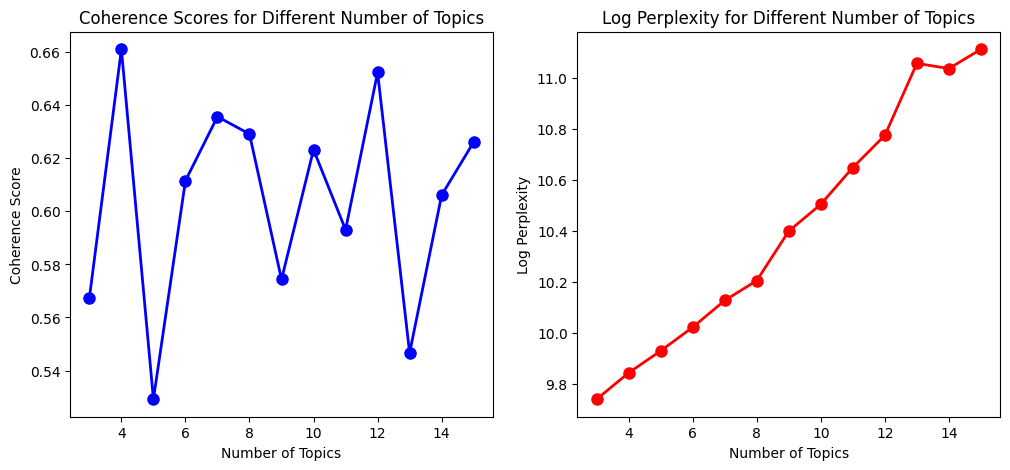

Best Number of Topics: 4
Topic 0:
['breton', 'dsa', 'chee', 'foo', 'yun', 'arma', 'ad', 'wrapper', 'advertiser', 'antitrust', 'yaccarino', 'jourova', 'chew', 'ibm', 'thierry', 'marketmoving', 'merger', 'bennet', 'zuckerberg', 'rogatory', 'subscription', 'content', 'musk', 'metao', 'complies']
Topic 1:
['norfolk', 'friendsgiving', 'thanksgiving', 'wonka', 'potato', 'uso', 'nikhinson', 'casserole', 'pardoning', 'spooned', 'flagbedecked', 'nantucket', 'cohosted', 'willy', 'mashed', 'diner', 'reutersjulia', 'sinew', 'musical', 'irvine', 'eljaru', 'fantasy', 'apron', 'hangar', 'spine']
Topic 2:
['israel', 'gaza', 'palestinian', 'israeli', 'hamas', 'people', 'attack', 'war', 'group', 'killed', 'state', 'military', 'conflict', 'minister', 'official', 'bank', 'west', 'civilian', 'aid', 'militant', 'hospital', 'reporting', 'united', 'security', 'oct']
Topic 3:
['market', 'oil', 'price', 'rate', 'index', 'inflation', 'investor', 'stock', 'crude', 'barrel', 'yield', 'data', 'bond', 'fed', 'higher

In [4]:
models, X, df = lda_topic_modeling_tfidf(df, 'preprocessed_text', use_tfidf=True)

In analyzing the results from our Latent Dirichlet Allocation (LDA) topic modeling, we've gleaned several insightful observations about the dataset and our model's performance. The coherence score, a pivotal metric in topic modeling, assesses the interpretability and significance of the words within each topic when viewed collectively. Our model, configured to generate four topics, achieved the highest coherence score (0.6611), indicating that this setup yielded the most semantically coherent and interpretable set of topics. We observed a fluctuation in coherence scores across different numbers of topics, a common occurrence in LDA modeling, as different configurations capture various degrees of thematic complexity. Our results showed an increase in log perplexity with more topics, which might suggest a tendency towards overfitting in models with a larger number of topics.

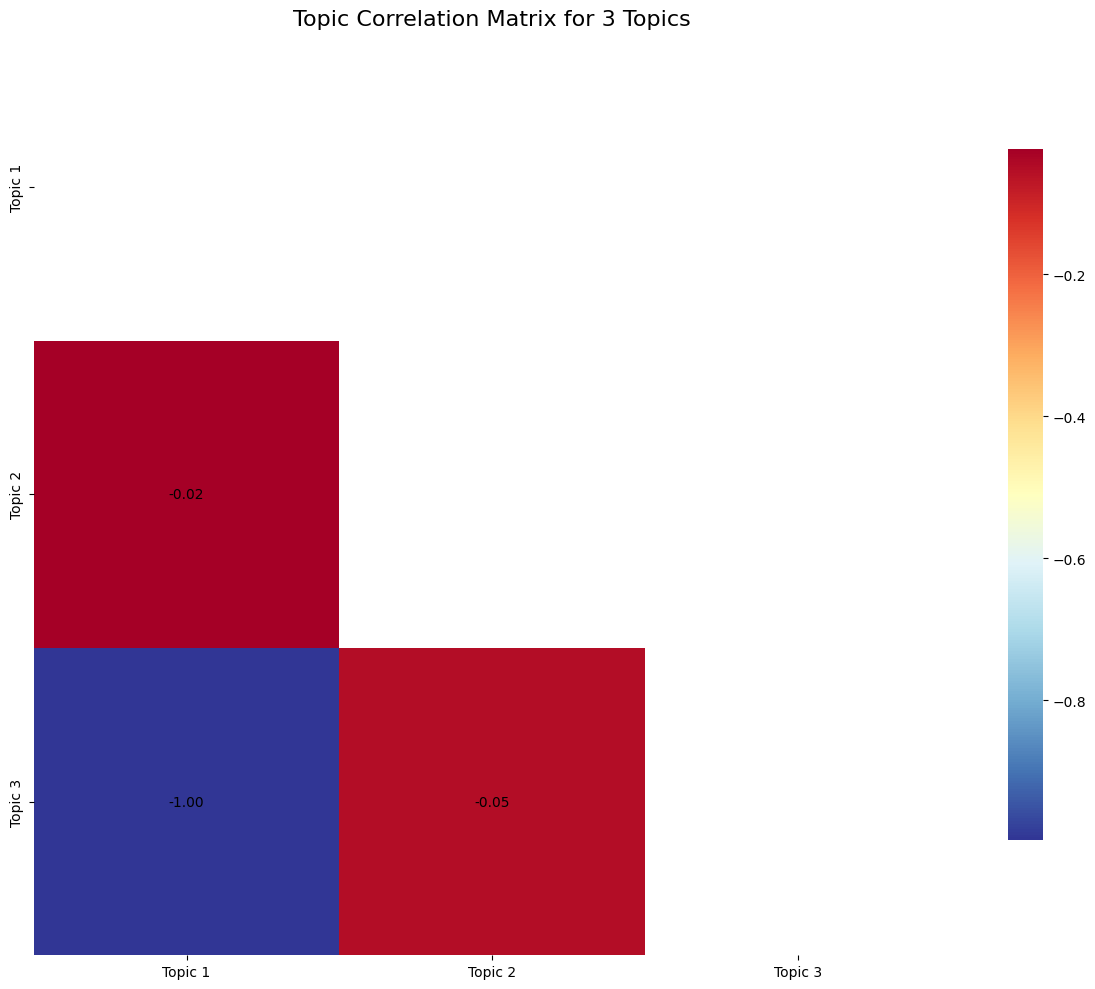

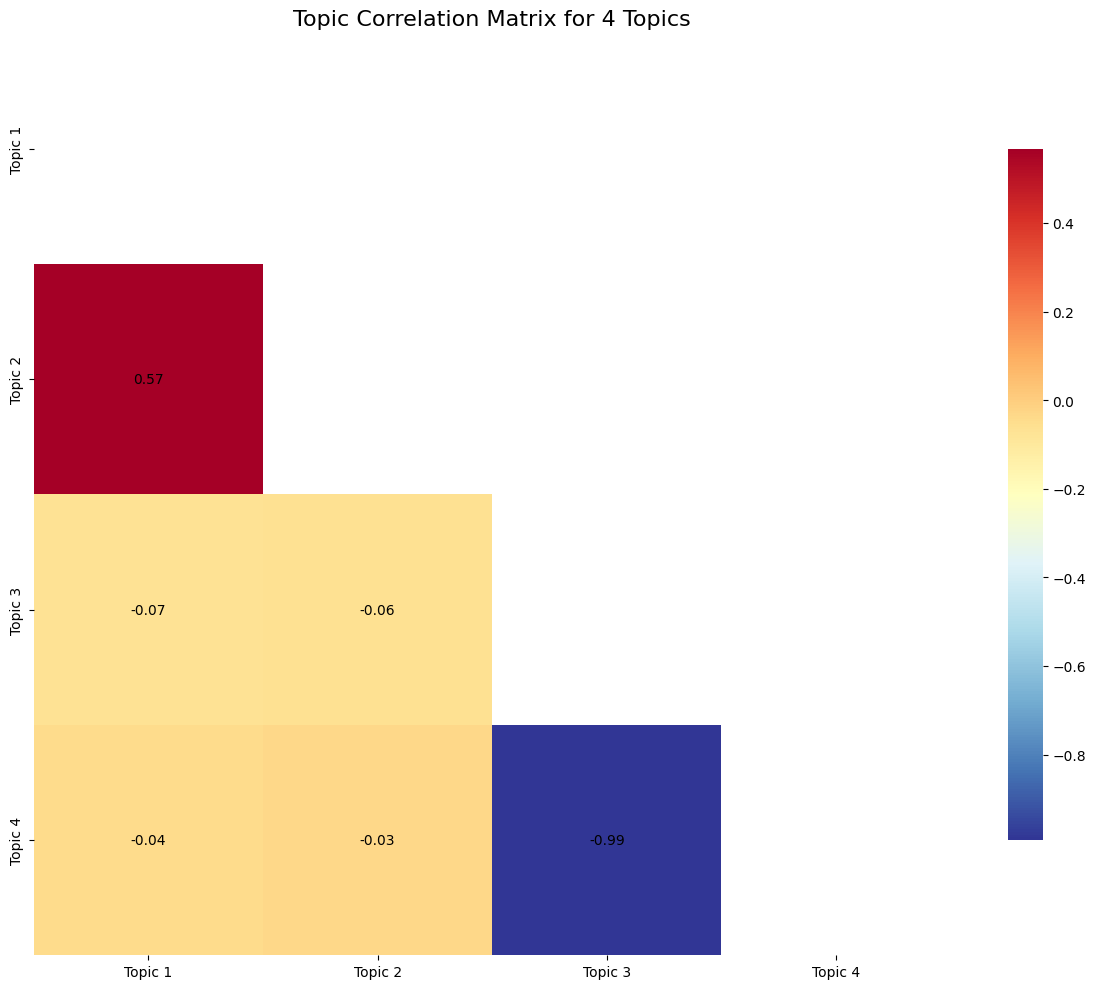

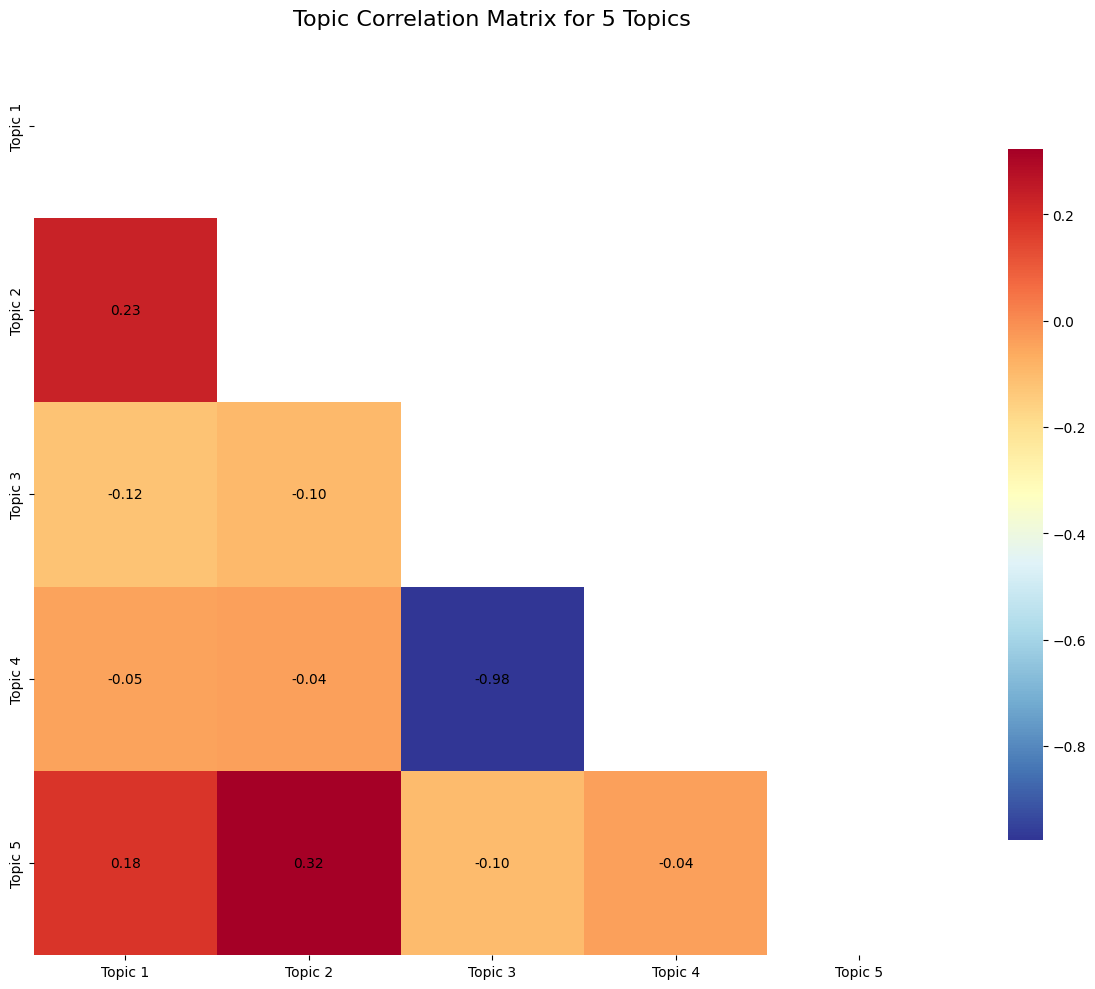

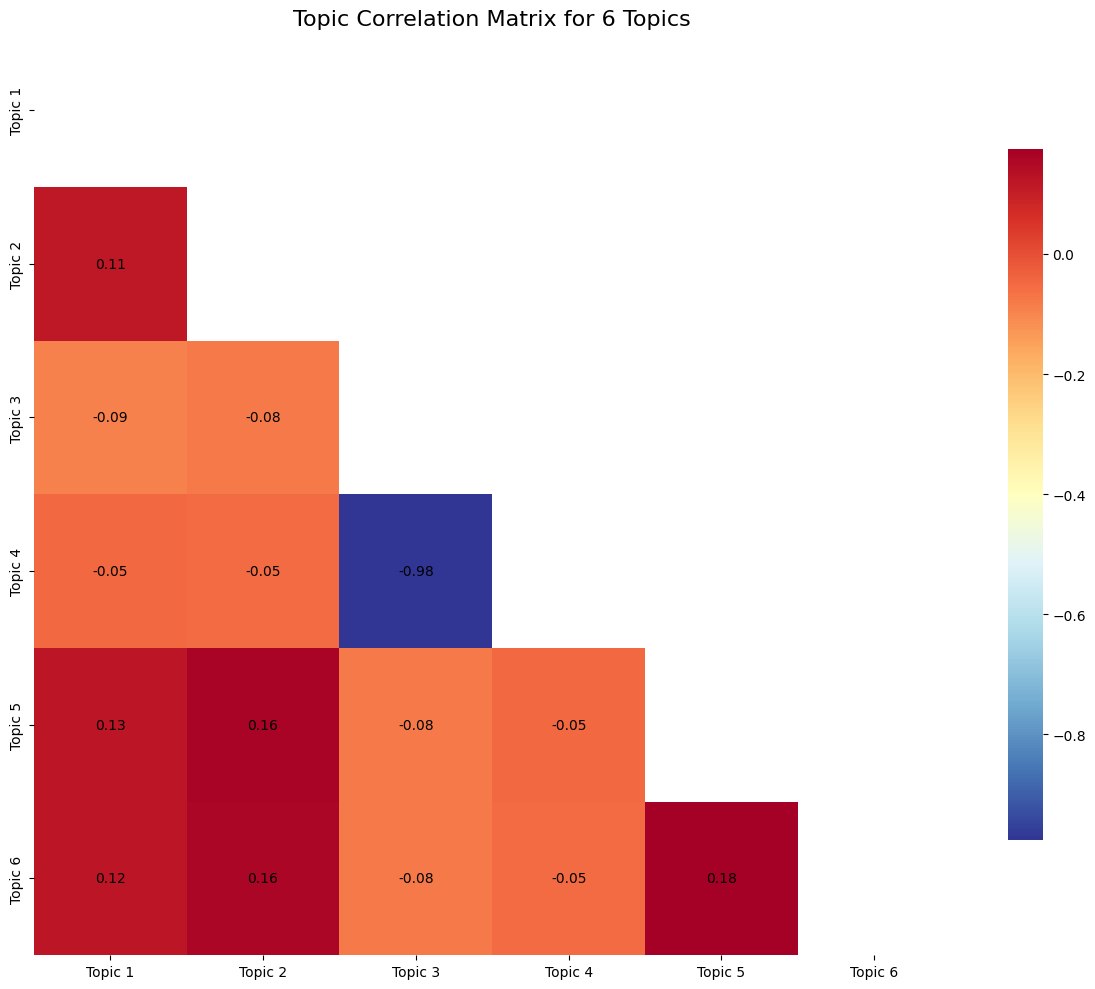

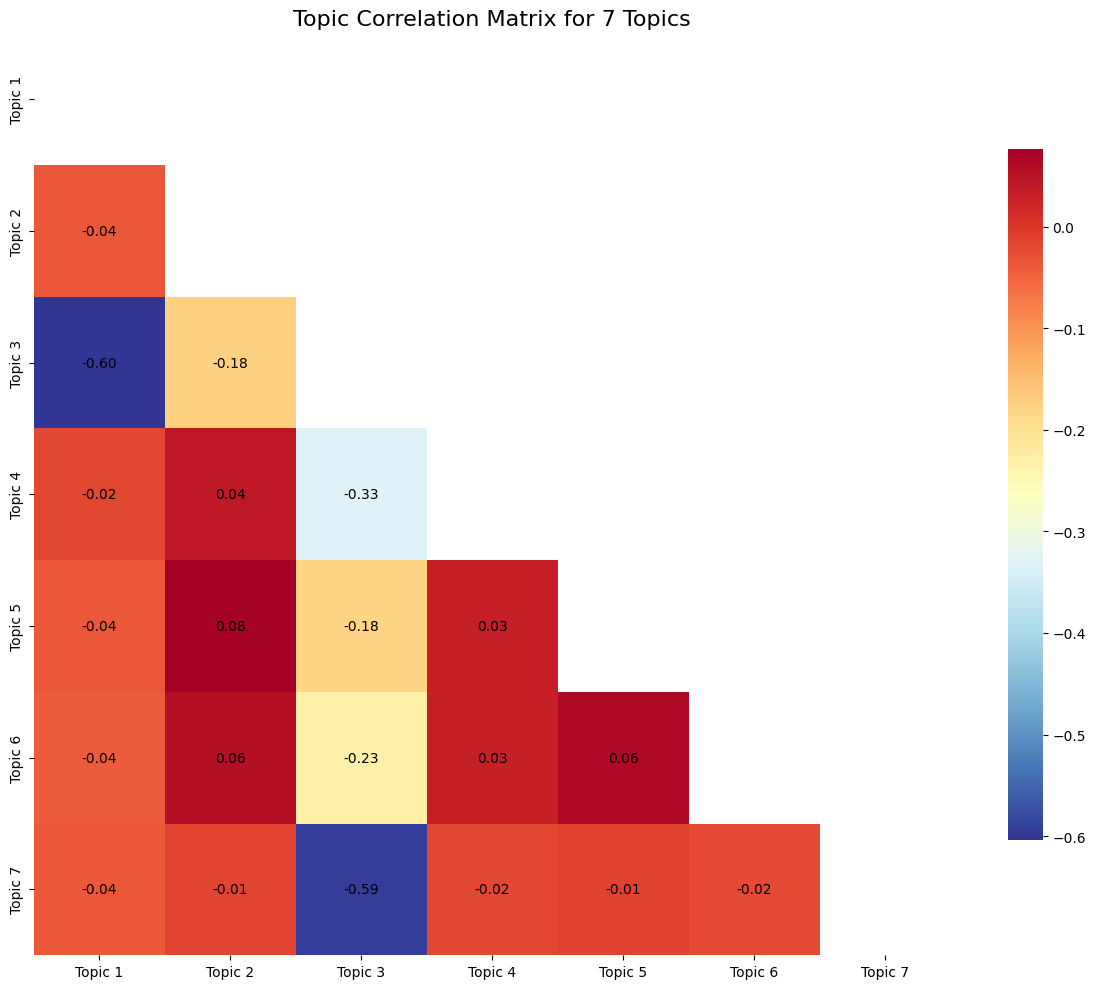

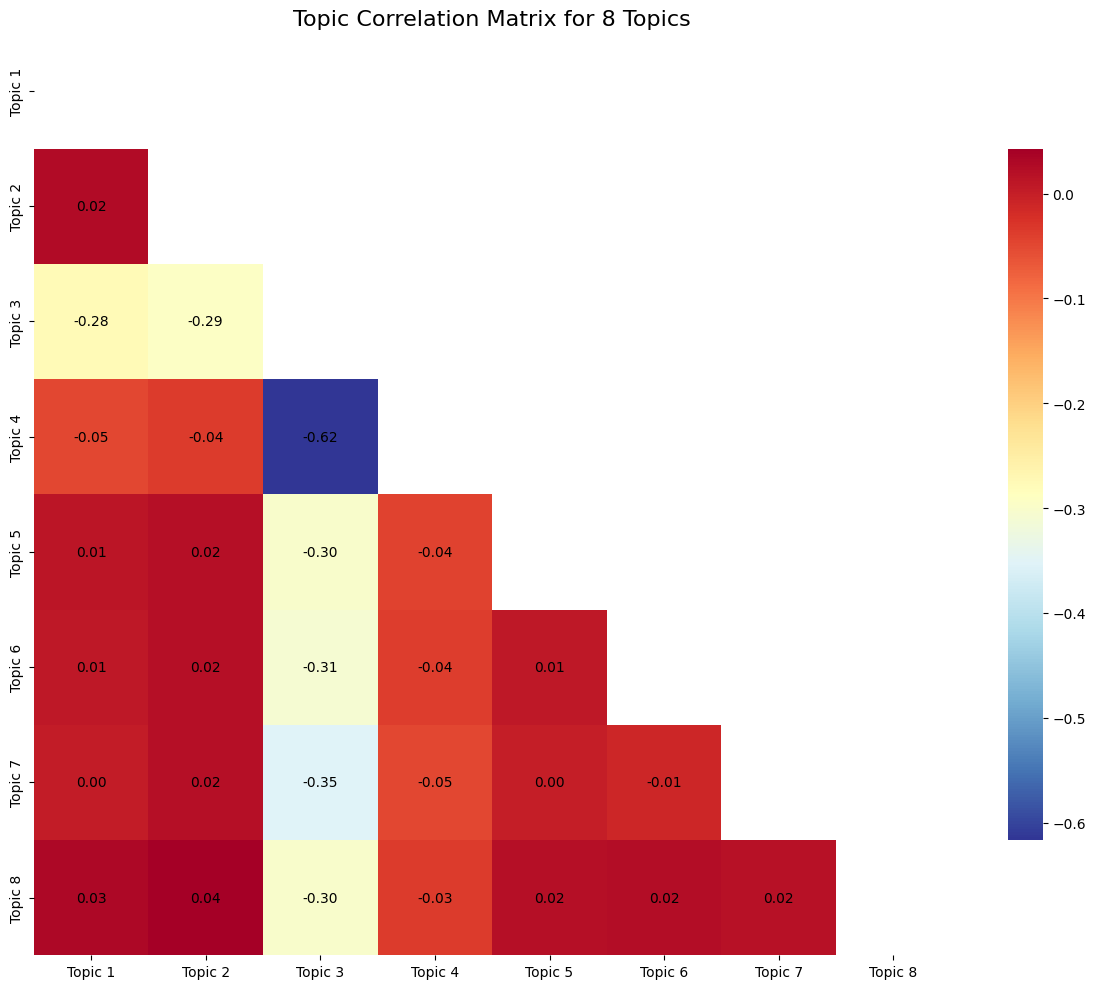

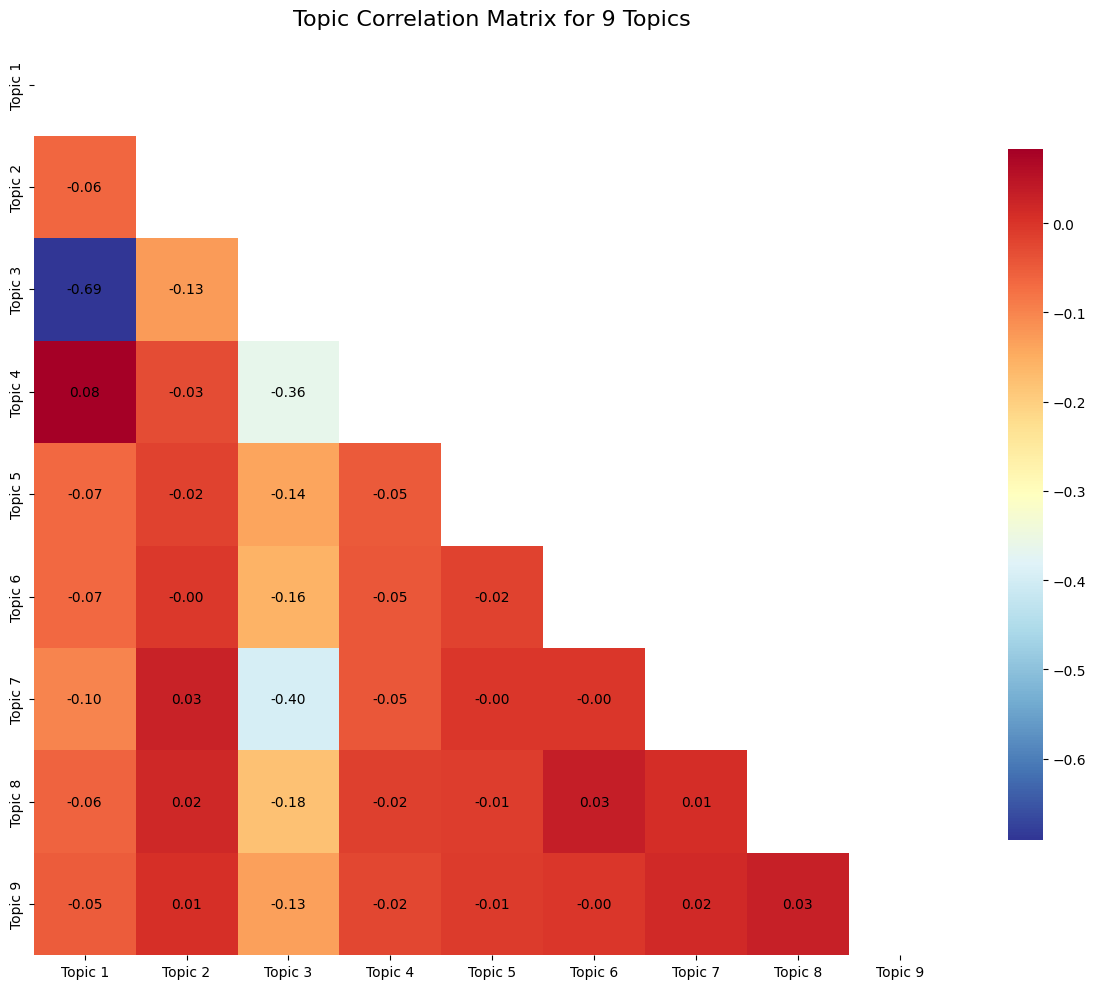

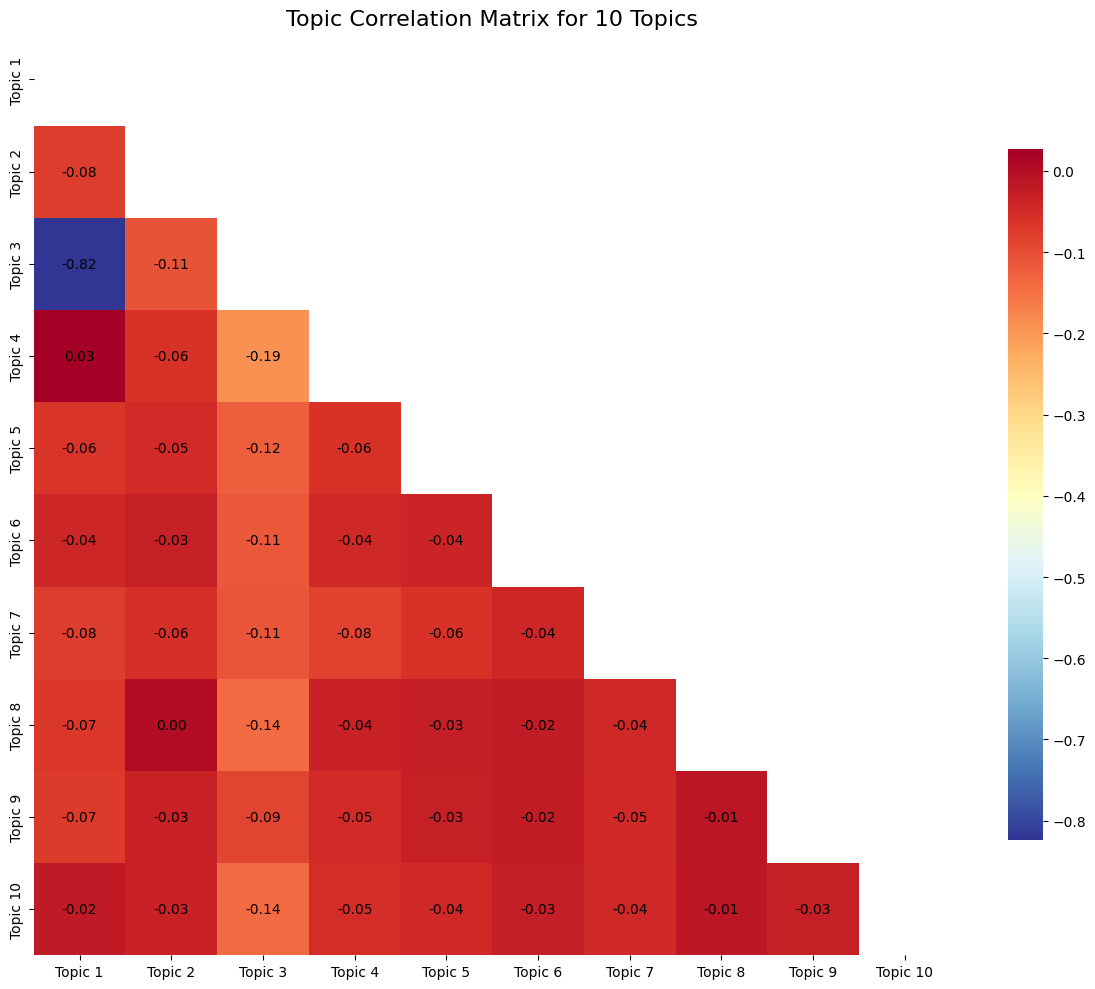

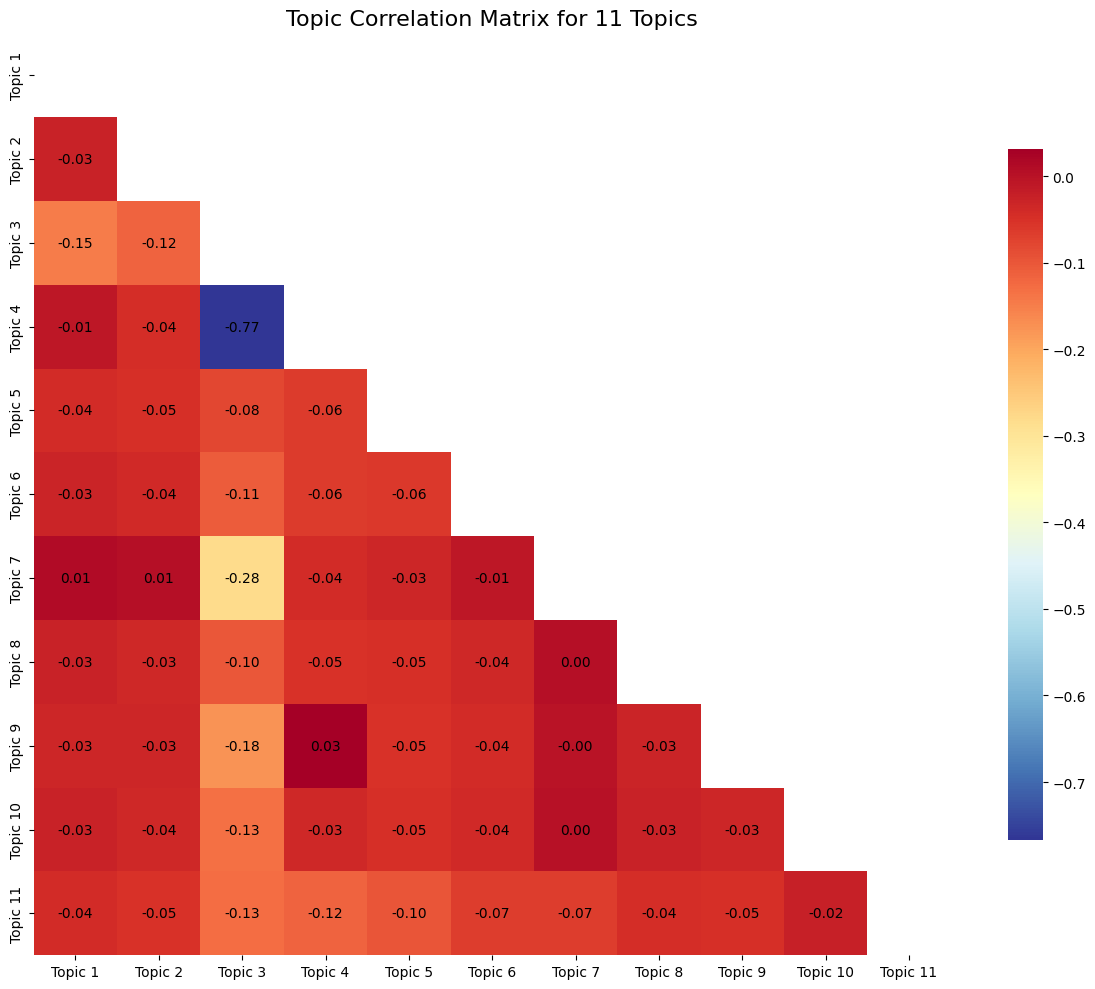

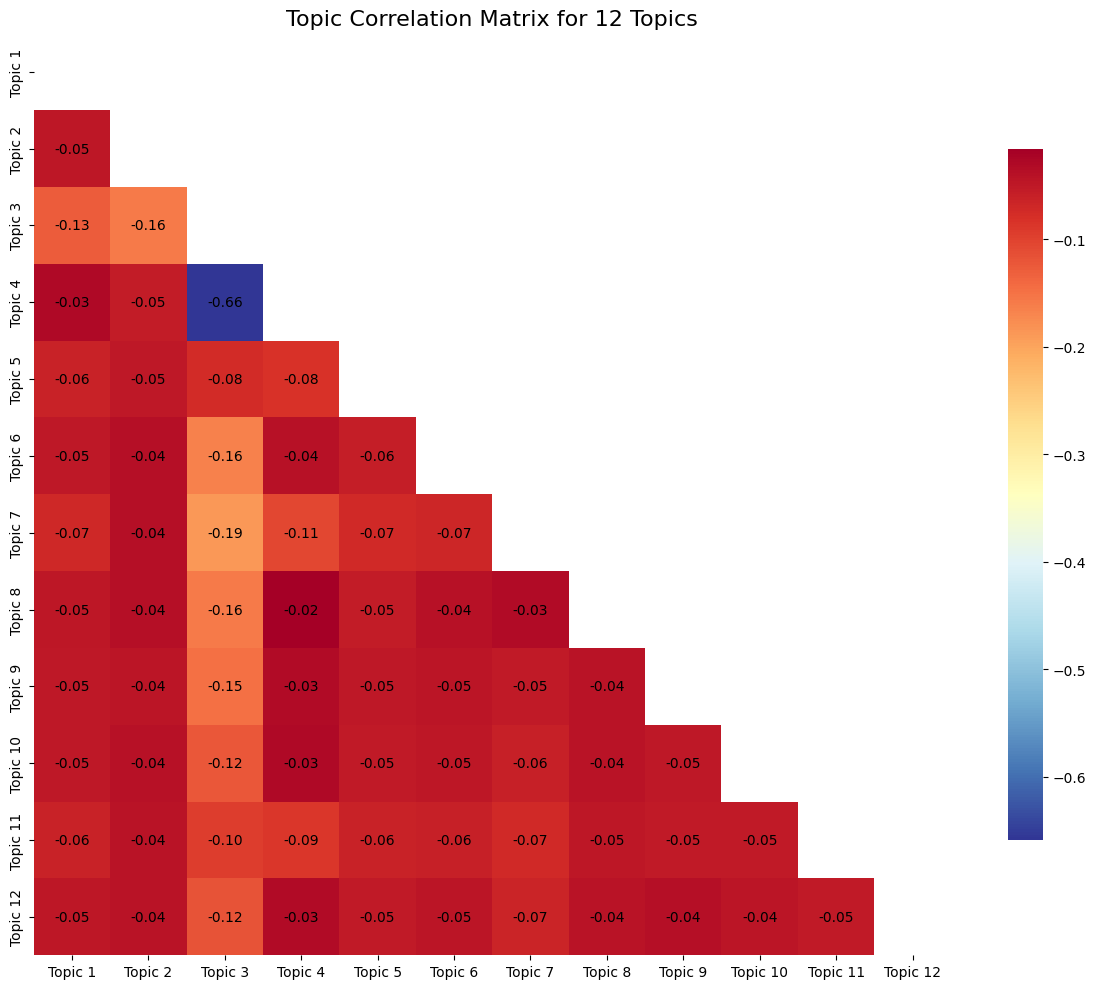

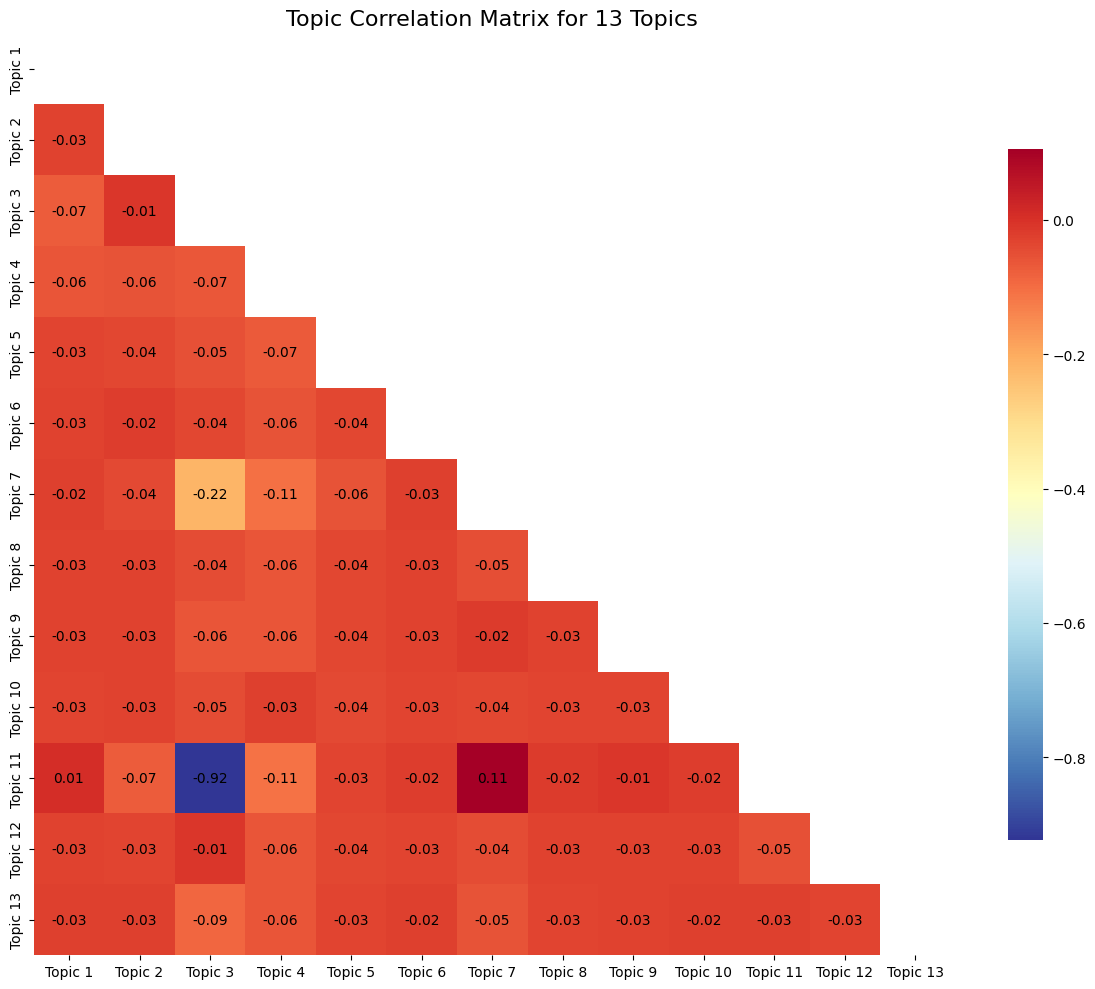

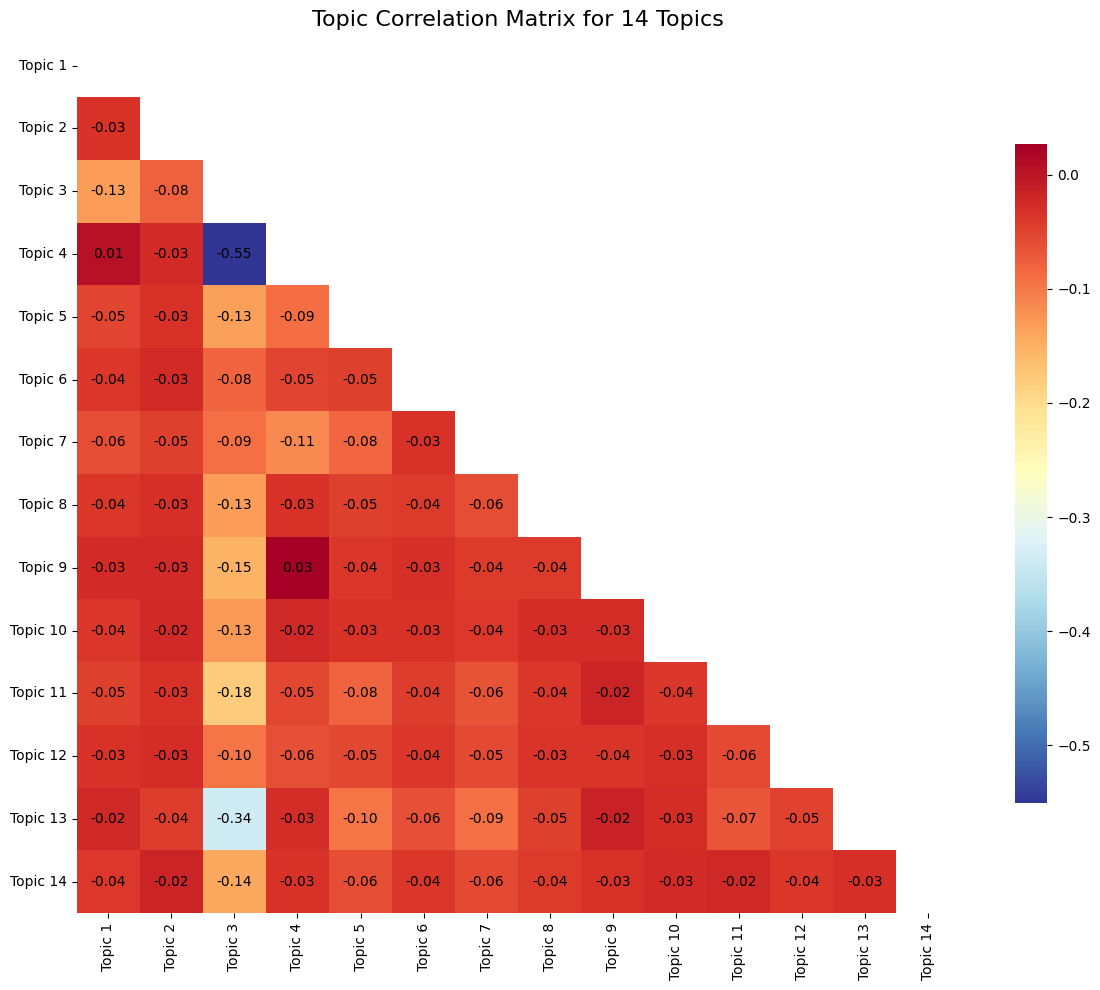

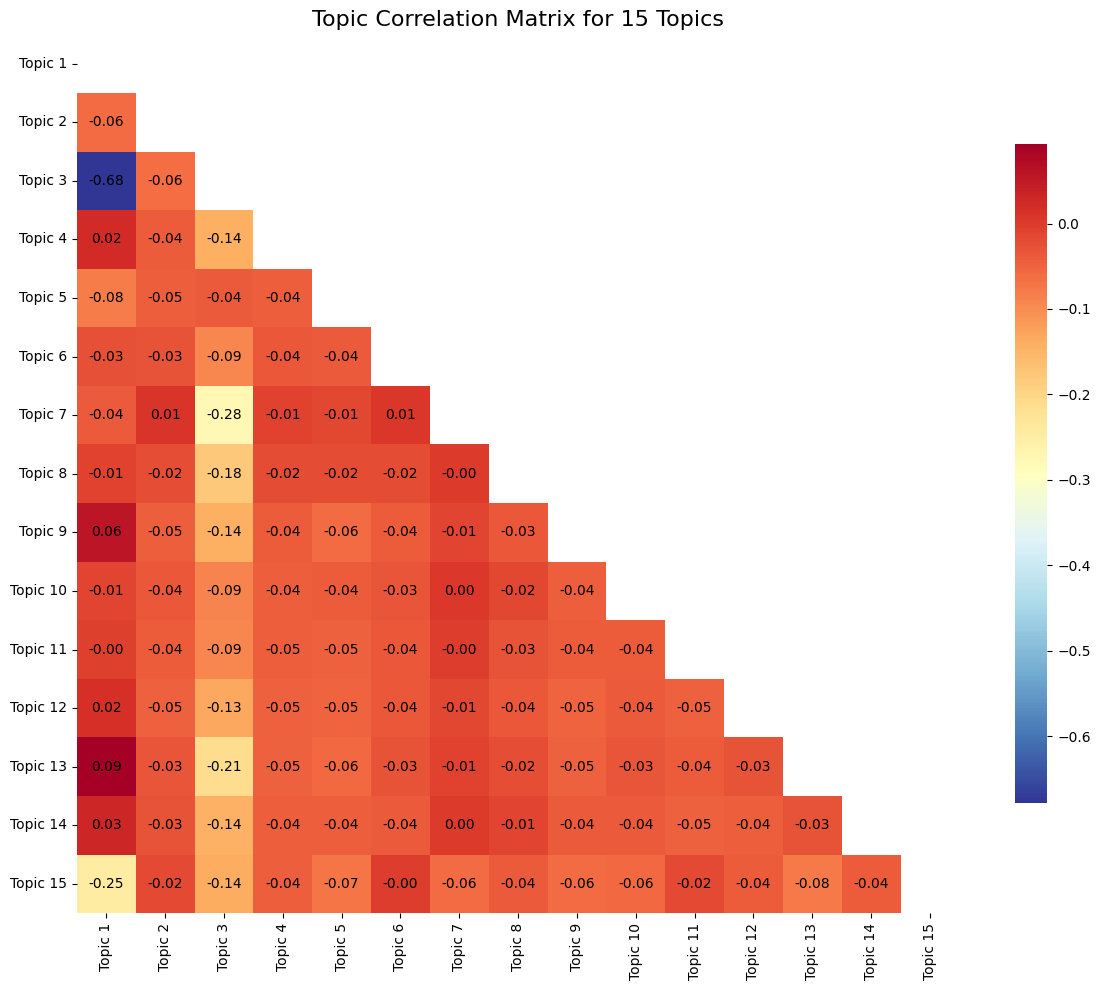

In [5]:
topic_correlation_analysis(models, X, range(3, 16), "topic_correlation_analysis")

In [6]:
topic_titles = {
    0: "Advertising and Market Dynamics in the Context of Israel-Hamas Reporting",
    1: "Cultural and Social Aspects in Israel-Hamas Coverage",
    2: "Israeli-Palestinian Conflict: The Gaza Perspective",
    3: "Economic and Financial Implications in Israel-Hamas Narratives"
}

df = add_topic_titles(df, topic_titles)
df.head(5)

,title,url,date,source,text,preprocessed_text,Dominant_Topic,Topic_Title
0,X's CEO tells staff data will show efforts to ...,https://www.reuters.com/technology/xs-ceo-tell...,"November 20, 2023",Reuters,Nov 20 (Reuters) - Social media company X CEO ...,social medium company x ceo linda yaccarino to...,2,Israeli-Palestinian Conflict: The Gaza Perspec...
1,Premature Gaza babies evacuated to Egypt as Is...,https://www.reuters.com/world/middle-east/isra...,"November 20, 2023",Reuters,"GAZA/JERUSALEM, Nov 20 (Reuters) - Twenty-eigh...",twentyeight prematurely born baby evacuated ga...,2,Israeli-Palestinian Conflict: The Gaza Perspec...
2,U.S. Democrats urge Biden to push Israel over ...,https://www.reuters.com/world/us-democrats-urg...,"November 20, 2023",Reuters,"WASHINGTON, Nov 20 (Reuters) - A group of U.S....",group president joe bidens fellow democrat urg...,2,Israeli-Palestinian Conflict: The Gaza Perspec...
3,Red Cross president meets with Hamas leader in...,https://www.reuters.com/world/middle-east/red-...,"November 20, 2023",Reuters,"GENEVA, Nov 20 (Reuters) - The International R...",international red cross president travelled qa...,2,Israeli-Palestinian Conflict: The Gaza Perspec...
4,2024 US presidential election: Who are the can...,https://www.reuters.com/world/us/who-are-candi...,"November 20, 2023",Reuters,Nov 20 (Reuters) - Seven Republican candidates...,seven republican candidate jostling party pres...,2,Israeli-Palestinian Conflict: The Gaza Perspec...


The titles we chose for each topic  
* "Advertising and Market Dynamics in the Context of Israel-Hamas Reporting" 
* "Cultural and Social Aspects in Israel-Hamas Coverage"
* "Israeli-Palestinian Conflict: The Gaza Perspective"
* "Economic and Financial Implications in Israel-Hamas Narratives"

were carefully crafted to encapsulate the core essence of the top words in each topic. These titles range from specific geopolitical issues to broader thematic areas, showcasing the diversity of topics in our dataset.

C:\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Python310\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


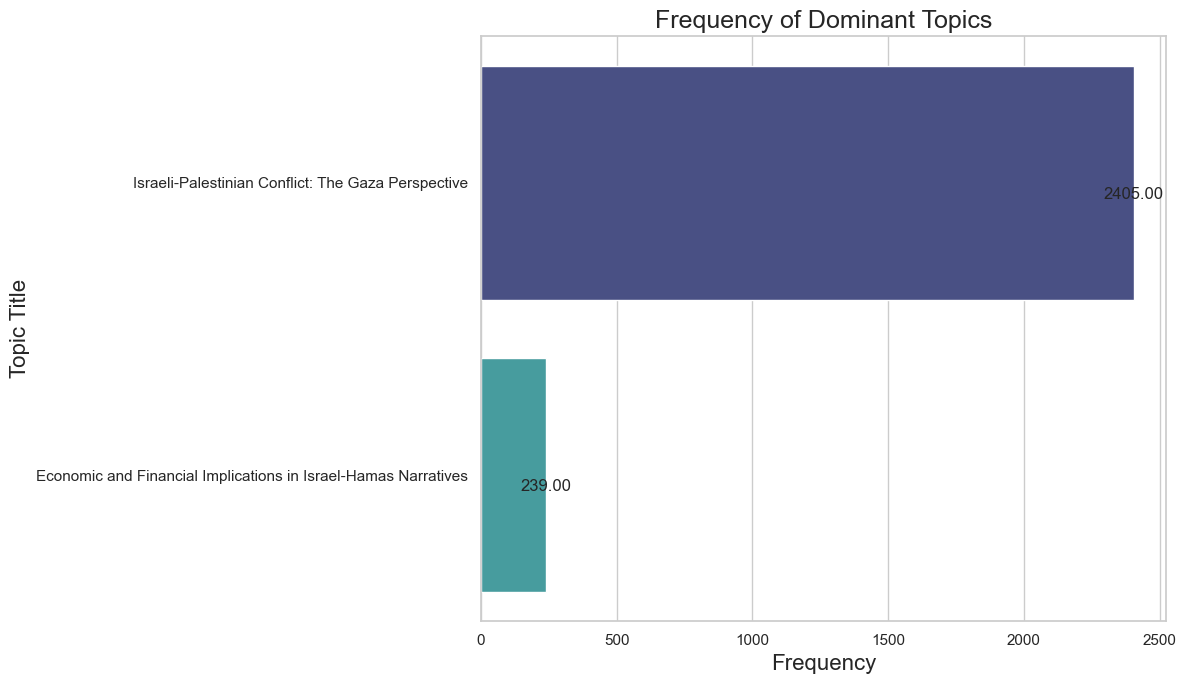

In [7]:
plot_topic_frequencies(df,'Dominant_Topic','Topic_Title')

However, the finding that only the second and third topics were dominant in our dataset is particularly noteworthy. This could reflect the content focus of our dataset, possibly indicating a larger volume of documents related to the Israeli-Palestinian conflict, especially those focusing on cultural, social, and geopolitical aspects. This dominance might also point to a skew in our dataset towards these topics, potentially due to the nature of the collected documents or the specific time frame of their collection.  

The less prevalent or absent representation of the other two topics in the dominant topic distribution might suggest either a lower emphasis on those areas in the documents or a limitation in our model's capacity to capture the dataset's full thematic breadth.

In [8]:
df.to_pickle('./Datasets/topics_lda.pkl')

### Topic Modelling:  Latent semantic indexing  (LSI) 

In [9]:
df = pd.read_pickle('./Datasets/preprocessed_news.pkl')
df.head(5)

,title,url,date,source,text,preprocessed_text
0,X's CEO tells staff data will show efforts to ...,https://www.reuters.com/technology/xs-ceo-tell...,"November 20, 2023",Reuters,Nov 20 (Reuters) - Social media company X CEO ...,social medium company x ceo linda yaccarino to...
1,Premature Gaza babies evacuated to Egypt as Is...,https://www.reuters.com/world/middle-east/isra...,"November 20, 2023",Reuters,"GAZA/JERUSALEM, Nov 20 (Reuters) - Twenty-eigh...",twentyeight prematurely born baby evacuated ga...
2,U.S. Democrats urge Biden to push Israel over ...,https://www.reuters.com/world/us-democrats-urg...,"November 20, 2023",Reuters,"WASHINGTON, Nov 20 (Reuters) - A group of U.S....",group president joe bidens fellow democrat urg...
3,Red Cross president meets with Hamas leader in...,https://www.reuters.com/world/middle-east/red-...,"November 20, 2023",Reuters,"GENEVA, Nov 20 (Reuters) - The International R...",international red cross president travelled qa...
4,2024 US presidential election: Who are the can...,https://www.reuters.com/world/us/who-are-candi...,"November 20, 2023",Reuters,Nov 20 (Reuters) - Seven Republican candidates...,seven republican candidate jostling party pres...


Topics: 3, Coherence Score: 0.4730797208246444
Topics: 4, Coherence Score: 0.42213284833184456
Topics: 5, Coherence Score: 0.4320655801897549
Topics: 6, Coherence Score: 0.4586162412749009
Topics: 7, Coherence Score: 0.43372704141351687
Topics: 8, Coherence Score: 0.4195350436223438
Topics: 9, Coherence Score: 0.4017282773289923
Topics: 10, Coherence Score: 0.39345720805027934
Topics: 11, Coherence Score: 0.39829344295117314
Topics: 12, Coherence Score: 0.38785438627663527
Topics: 13, Coherence Score: 0.3688344084273837
Topics: 14, Coherence Score: 0.3605658764679968
Topics: 15, Coherence Score: 0.35049672292274575


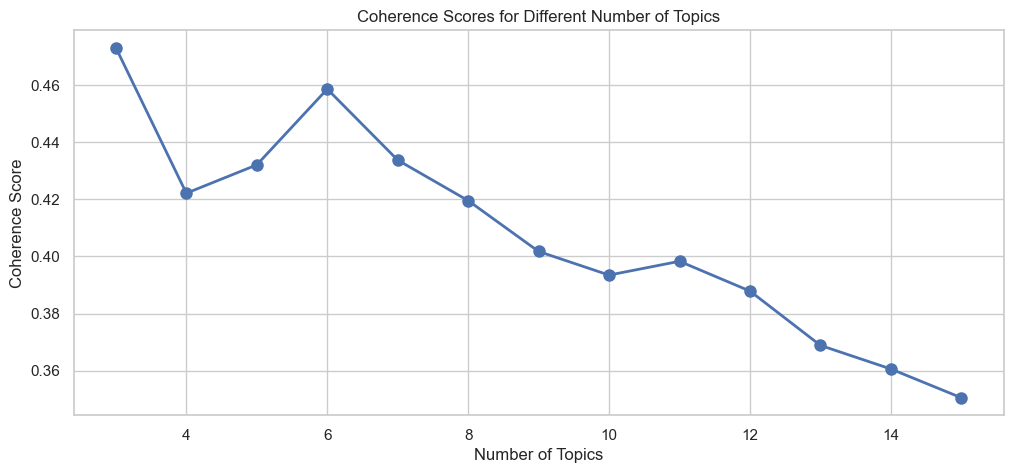

Best Number of Topics: 3
Topic 0:
['israel', 'gaza', 'palestinian', 'israeli', 'hamas', 'people', 'killed', 'attack', 'military', 'state', 'bank', 'war', 'group', 'west', 'official', 'civilian', 'hospital', 'aid', 'conflict', 'minister', 'strike', 'militant', 'force', 'humanitarian', 'hostage']
Topic 1:
['oil', 'market', 'price', 'rate', 'index', 'israeli', 'gaza', 'inflation', 'crude', 'barrel', 'stock', 'investor', 'yield', 'palestinian', 'fed', 'hospital', 'dollar', 'global', 'economy', 'billion', 'data', 'bond', 'higher', 'saudi', 'treasury']
Topic 2:
['bank', 'west', 'aid', 'palestinian', 'israeli', 'humanitarian', 'biden', 'gaza', 'jerusalem', 'jenin', 'police', 'egypt', 'hostage', 'force', 'settler', 'rafah', 'raid', 'crossing', 'blinken', 'city', 'violence', 'jihad', 'pause', 'shot', 'united']


In [10]:
# Calling the function
models, transformed_corpus, updated_dataframe = lsi_topic_modeling_tfidf(
    df=df, 
    column='preprocessed_text', 
    use_tfidf=True, 
    n_topics_range=range(3, 16), 
    n_top_words=25
)

In our analysis of the Latent Semantic Indexing (LSI) model results, we observed several notable trends, particularly when compared to the LDA model. The coherence scores in the LSI model showed a general decrease as the number of topics increased, with the highest coherence observed at three topics (0.4731). This suggests that the 3-topic model was more coherent than models with more topics, indicating a potential struggle to maintain thematic clarity with increased granularity. 



In [11]:
topic_titles = {
    0: "Reuters Analysis: Israeli-Hamas Conflict and Its Humanitarian Impact",
    1: "Economic Insights from Reuters: Oil Markets and Global Financial Trends Amidst Israeli-Hamas Tensions",
    2: "Reuters Coverage on West Bank: Aid, Diplomacy, and Israeli-Palestinian Relations"
}

df = add_topic_titles(df, topic_titles)
df.head(5)

,title,url,date,source,text,preprocessed_text,Dominant_Topic,Topic_Title
0,X's CEO tells staff data will show efforts to ...,https://www.reuters.com/technology/xs-ceo-tell...,"November 20, 2023",Reuters,Nov 20 (Reuters) - Social media company X CEO ...,social medium company x ceo linda yaccarino to...,0,Reuters Analysis: Israeli-Hamas Conflict and I...
1,Premature Gaza babies evacuated to Egypt as Is...,https://www.reuters.com/world/middle-east/isra...,"November 20, 2023",Reuters,"GAZA/JERUSALEM, Nov 20 (Reuters) - Twenty-eigh...",twentyeight prematurely born baby evacuated ga...,0,Reuters Analysis: Israeli-Hamas Conflict and I...
2,U.S. Democrats urge Biden to push Israel over ...,https://www.reuters.com/world/us-democrats-urg...,"November 20, 2023",Reuters,"WASHINGTON, Nov 20 (Reuters) - A group of U.S....",group president joe bidens fellow democrat urg...,0,Reuters Analysis: Israeli-Hamas Conflict and I...
3,Red Cross president meets with Hamas leader in...,https://www.reuters.com/world/middle-east/red-...,"November 20, 2023",Reuters,"GENEVA, Nov 20 (Reuters) - The International R...",international red cross president travelled qa...,0,Reuters Analysis: Israeli-Hamas Conflict and I...
4,2024 US presidential election: Who are the can...,https://www.reuters.com/world/us/who-are-candi...,"November 20, 2023",Reuters,Nov 20 (Reuters) - Seven Republican candidates...,seven republican candidate jostling party pres...,0,Reuters Analysis: Israeli-Hamas Conflict and I...


The titles we assigned to each topic
* "Reuters Analysis: Israeli-Hamas Conflict and Its Humanitarian Impact," 
* "Economic Insights from Reuters: Oil Markets and Global Financial Trends Amidst Israeli-Hamas Tensions,"
* "Reuters Coverage on West Bank: Aid, Diplomacy, and Israeli-Palestinian Relations" 

effectively encapsulate the dominant themes of the topics, covering geopolitical, economic, and humanitarian angles.

C:\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Python310\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


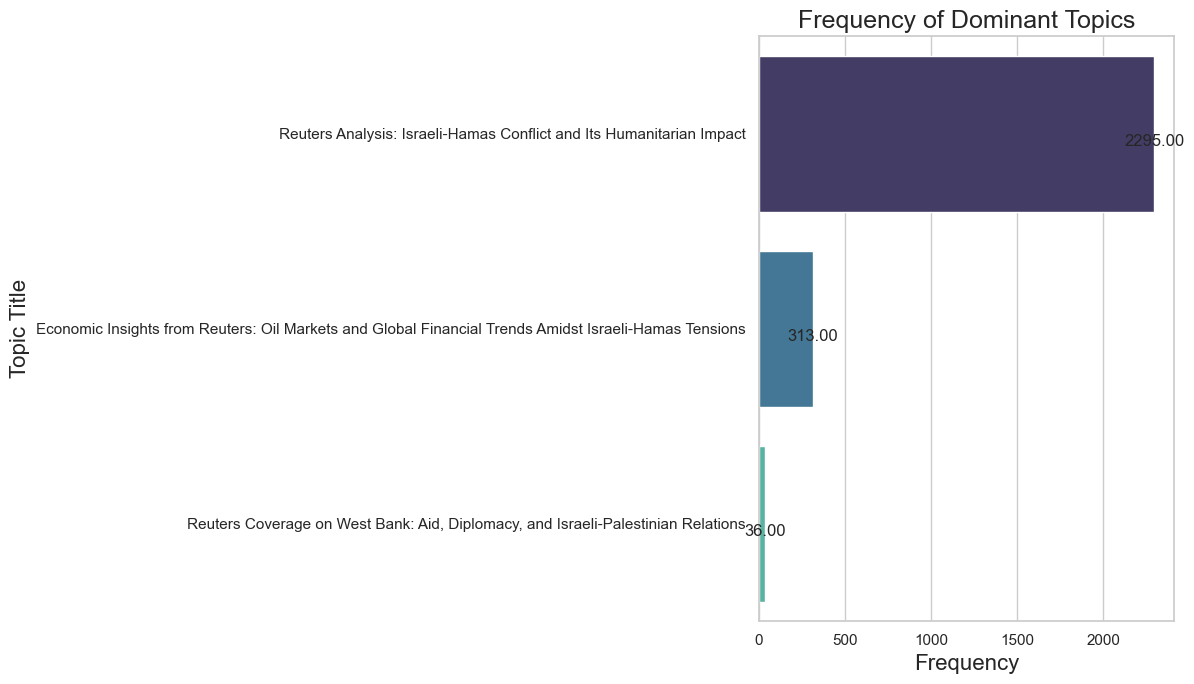

In [18]:
plot_topic_frequencies(df,'Dominant_Topic','Topic_Title')

The distribution of dominant topics was notably skewed, with the first topic being significantly more prevalent than the others. This skewness indicates a strong emphasis in our dataset on the aspects of the Israeli-Hamas conflict and its humanitarian impact, potentially reflecting the nature of the data collection or the specific time period covered. This observation is critical as it highlights the dataset's content focus, which might be concentrated on certain events or issues.

In [19]:
df.to_pickle('./Datasets/topics_lsi.pkl')

Comparatively, the LSI model's emphasis on one dominant topic suggests a pattern of topic distribution that differs from the probabilistic approach of LDA, offering a unique perspective on the dataset. This difference in methodologies between LSI and LDA can lead to varied interpretations of the underlying themes in the data.

As a conclusion to our analysis of topic modeling methods, we have decided to proceed with the Latent Dirichlet Allocation (LDA) approach for the next phase of our project, which involves sentiment analysis. 